# CS4243 Assignment 3

The goal of this assignment is to do image stitching -- how multiple images can form a panorama. To do this, you would need to implement feature detectors, feature descriptors, and keypoints matching algorithms (transformation estimation is done for your convenience).

## Assignment Guideline (Carefully Read Before Coding)

Please create a new environment (do **NOT** use the same environment as in previous assignments to prevent from version conflict) and install all requirements with `pip install -r requirements.txt`. You are required to finish this notebook by successfully **(1) running all of the segments, (2) producing results and (3) answering all of the questions**. 

In this assignment, you are required to implement the key components of each step by filling the missing code segments in `image_stitching.py`. You can edit `image_stitching.py` with any editor/IDE (e.g. PyCharm) you are comfortable with. Before running the code segments, make sure the notebook are running in a virtual environment that has installed all required packages in `requirements.txt`. After you finish filling a code segment, make sure to save it before you run the related cells of this notebook (the notebook will automatically re-load your code in `image_stitching.py`) to check if the results are correct.

### Submission Guideline

After you finish the code and get all the results, **(1) re-run this notebook (and make sure you get all the clean outputs), (2) zip the same folder back and name it with your student ID (e.g. A0123456H.zip) and (3) submit to the NUS Luminus system **. Please be careful since any failure to follow the submission guideline will result in a grade deduction.

In [21]:
# Setup
from __future__ import print_function
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Goal: Image Stitching

Image stitching is the process of combining multiple photographic images with overlapping fields of view to produce a segmented panorama or high-resolution image. Since Brown Matthew and David G. Lowe published [Automatic Panoramic Image Stitching using Invariant Features](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007, this technique has quickly been widely-used in many applications such as Google Street View, panaroma function in smartphones and image stitching softwares.

This assignment consists of the following parts:

1. Detecting keypoints with corner detectors (Harris, etc.). (**10 points**)

2. Extracting local (simple) descriptors from two input images and compare two sets of descriptors coming from two different images and find matching keypoints. (**30 points incl. discussion**) 
   - Discussion #1 (2 points)

3. Then use DLT algorithm to find the homography matrix that maps points in one image to another, and use it to transform the second image and overlay it on the first image, forming a panorama. (**20 points incl. discussion**)
   - Discussion #1 (2 points)

4. Try RANSAC descriptor matching algorithm to get a better result (**20 points incl. discussion**)
   - Discussion #2 (2 points)

5. Implement a different descriptor (SIFT) to see the results. (**20 points incl. discussion**)
   - Discussion #3 (2 points)

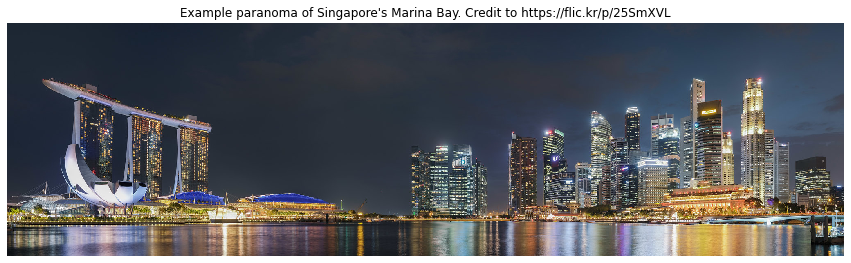

In [22]:
plt.imshow(imread('marina_bay.jpg'))
plt.axis('off')
plt.title('Example paranoma of Singapore\'s Marina Bay. Credit to https://flic.kr/p/25SmXVL')
plt.show()

## Part 1: Harris Corner Detector (10 points)

For keypoints detector, we adopt Harris Corner Detector. Refer to the lecture slides if you are still not familiar with it. Basically, there are 5 key steps in the algorithm:

1. Compute derivatives in x and y directions respectively of an image: ($I_x, I_y$) 
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
<br>
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$ 

**Implement `harris_corners` function and then run the code cells below.**

*-Hint: You may use the function `scipy.ndimage.filters.convolve`, which is already imported in `image_stitching.py`*

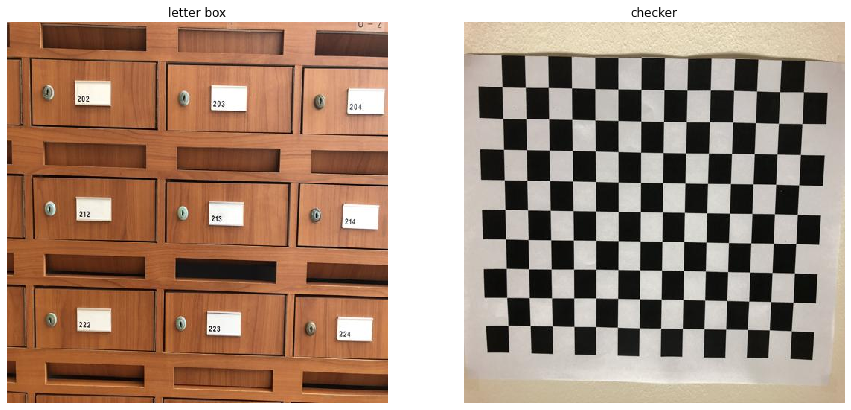

In [23]:
# Before working on the corner detectors, let's see how the original images look like

plt.subplot(1,2,1)
plt.imshow(imread('letterbox.jpg'))
plt.axis('off')
plt.title('letter box')

plt.subplot(1,2,2)
plt.imshow(imread('checker.jpg'))
plt.axis('off')
plt.title('checker')
plt.show()

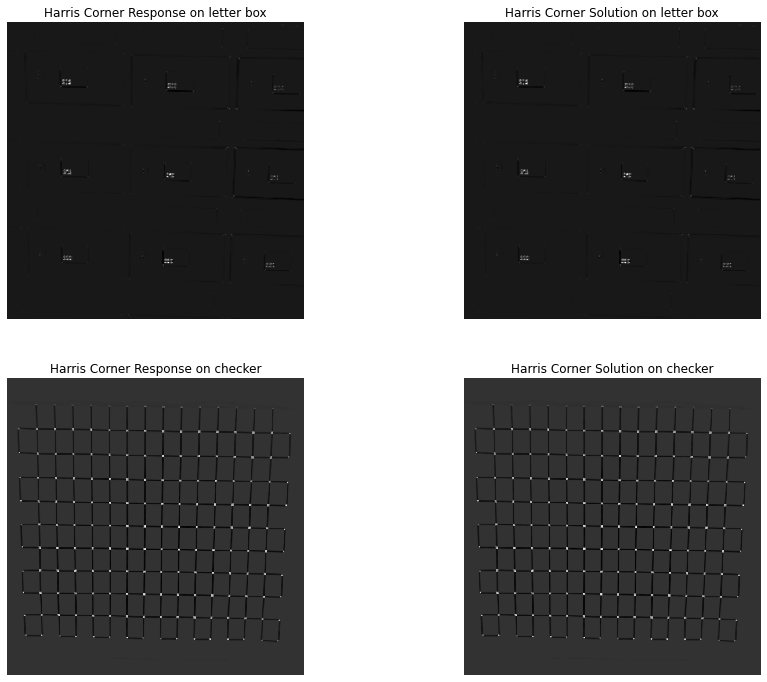

In [24]:
from image_stitching import harris_corners

img1 = imread('letterbox.jpg', as_gray=True)
img2 = imread('checker.jpg', as_gray=True)

# Compute Harris corner response
response1 = harris_corners(img1)
response2 = harris_corners(img2)

# Display corner response
plt.subplot(2,2,1)
plt.imshow(response1)
plt.axis('off')
plt.title('Harris Corner Response on letter box')

plt.subplot(2,2,2)
plt.imshow(imread('solution_harris_letterbox.jpg', as_gray=True))
plt.axis('off')
plt.title('Harris Corner Solution on letter box')

plt.subplot(2,2,3)
plt.imshow(response2)
plt.axis('off')
plt.title('Harris Corner Response on checker')

plt.subplot(2,2,4)
plt.imshow(imread('solution_harris_checker.jpg', as_gray=True))
plt.axis('off')
plt.title('Harris Corner Solution on checker')

plt.show()

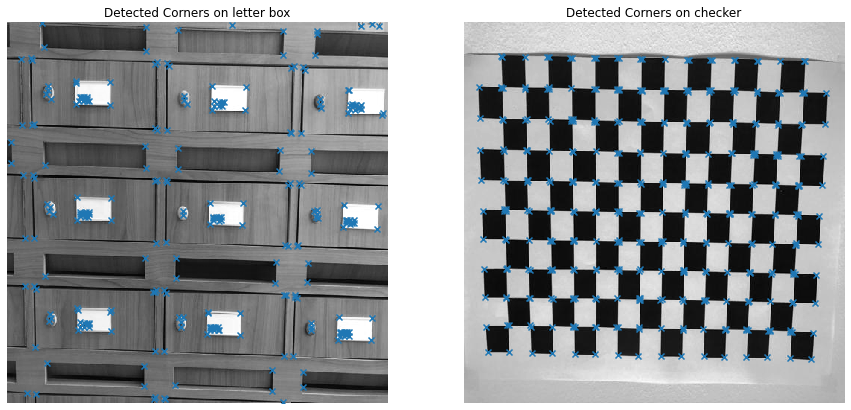

In [25]:
# Perform non-maximum suppression in response map
# and output corner coordiantes
corners1 = corner_peaks(response1, threshold_rel=0.01)
corners2 = corner_peaks(response2, threshold_rel=0.01)

# Display detected corners
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(corners1[:,1], corners1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners on letter box')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(corners2[:,1], corners2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners on checker')
plt.show()

## Part 2: Extracting and Matching keypoints (30 points)

## Part 2a: Keypoint Descriptor (14 points)

Now we are able to detect keypoints by running Harris corner detector independently on two images. However, how do we know which pair of keypoints come from the same location in those two images? In order to *match* the keypoints, we need to first *describe* the keypoints based on their local appearance. A simple idea is to take the region around the keypoint and convert into a fix-sized vector called **descriptor**. 

We first perform Harris corner detector on the two images we are going to work on.

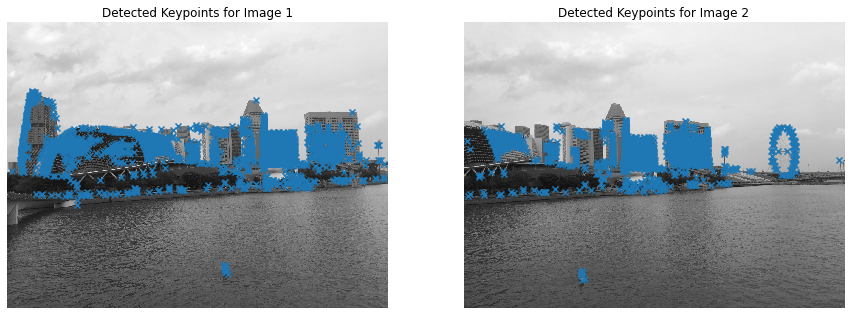

In [26]:
from image_stitching import harris_corners

img1 = imread('marinabay_a.jpg', as_gray=True)
img2 = imread('marinabay_b.jpg', as_gray=True)

img1_c = cv2.imread('marinabay_a.jpg')
img1_c = cv2.cvtColor(img1_c, cv2.COLOR_BGR2RGB)
img2_c = cv2.imread('marinabay_b.jpg')
img2_c = cv2.cvtColor(img2_c, cv2.COLOR_BGR2RGB)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

**Implement `simple_descriptor` function in `image_stitching.py`** before proceeding to the next section. The function will be used in the following descriptors matching.

*Hint: In **`simple_descriptor`** each keypoint is described by normalized intensity in a small patch around it.*

## Part 2b: Descriptors Matching (14 points)

Then, implement **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: if the distance to the closest vector is significantly (by a factor defined by match_threshold - you have to tune this parameter for best results) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

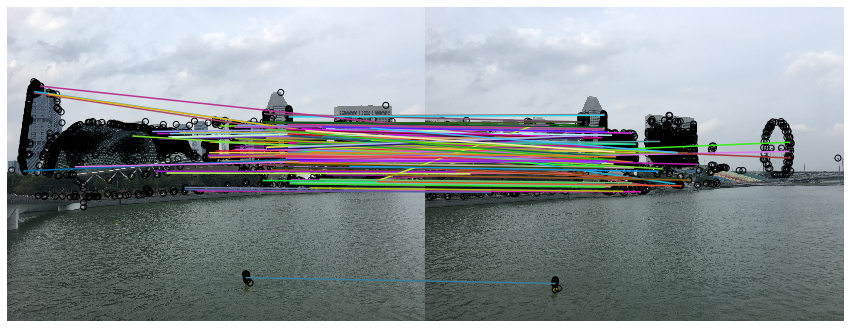

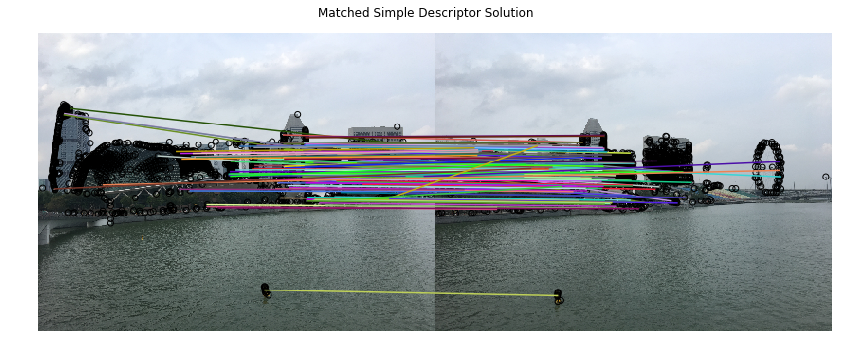

In [27]:
from image_stitching import simple_descriptor, match_descriptors, describe_keypoints
from utils import plot_matches

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match descriptors in image1 to those in image2
match_threshold = 0.7 
matches = match_descriptors(desc1, desc2, match_threshold)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1_c, img2_c, keypoints1, keypoints2, matches)
plt.show()

plt.imshow(imread('sol_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

## Discussion (2 points)
1. What are the disadvantage(s) of naive descriptor implemented in `simple_descriptor`, which takes the region around the keypoint as feature vector? Is it invariant to scale/rotation change? Give an example of a better approach.

Your answers:

Disadvantage one: 
* This approach is sensitive to scale/rotation change. Two similar patches but with different scale or rotation might not be matched.
Disadvantage two:
* It is poorly distinctive. We might also see more false matching keypoints described by this naive descriptor even if both are not related. 

The feature computed by this naive descriptor is only invariant to absolute intensity values. But it is not invariant to scale/rotation change.

A better approach would be to use SIFT descriptors.

END OF YOUR ANSWER

## Part 3: Homography Estimation (18 points)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that
$$
\tilde{p_2}H = \tilde{p_1},
$$
<br>
where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.
Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,
$$
X_2 H = X_1
$$
<br>
Implement **compute_homography**. Run the following code to apply it to images. The images will be warped and the two images are merged to get a panorama. Your panorama may not look good at this point, but we will later use other techniques to get better results.

The homography is supposed to be computed using DLT algorithm. You're not allowed to use cv2.findHomography(), np.linalg.solve() and np.linalg.lstsq() for this function. The trick is to use inhomogeneous solution for finding h

Also, implement the normalization trick as discussed in MVGeometry (Link is in Reference) Page 109.

Hints - 
Use np.linalg.svd() for computing homography using DLT algorithm. 

Refereces - <br>
http://vhosts.eecs.umich.edu/vision//teaching/EECS442_2011/lectures/discussion2.pdf<br>
https://www.dropbox.com/s/q0c7bhlugjkbja4/Hartley_MVGeometry.pdf?dl=0

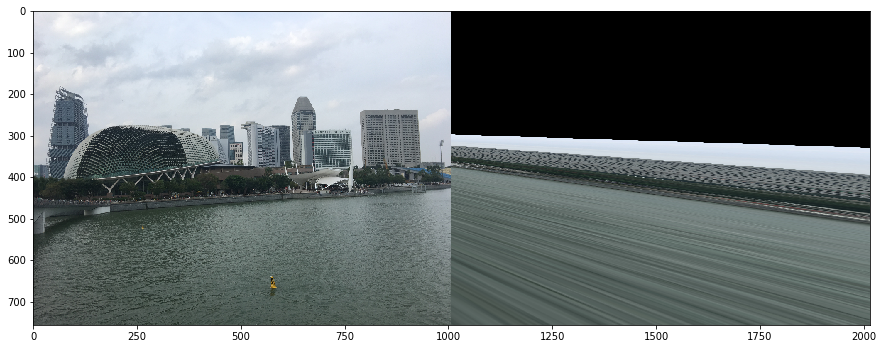

In [63]:
from image_stitching import compute_homography, warp_image
from image_stitching import trim

# Extract matched keypoints
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# For p1 and p2 the x-coordinate is at p1[:,1] and y at p1[:,0]. Swapping the columns for consistency.
p1[:, [0,1]] = p1[:, [1,0]]
p2[:, [0,1]] = p2[:, [1,0]]

# Compute Homography matrix H that maps p2 to p1
H = compute_homography(p1, p2)

final_im = trim(warp_image(img1_c, img2_c, H))
plt.imshow(final_im)

## Discussion (2 points)

1. As showed above, the image stitching does not work well as we expected to produce a smooth panorama. In fact, it is caused by Image 2 that skews largely. Why does it happen? What are the possible solution(s)? 

Your answers:
<br> (Delete all the < br> and this line before filling your answer)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
END OF YOUR ANSWER

## Part 4: RANSAC (RANdom SAmple Consensus) (18 points)

The results showed above may not be so pleasant. RANSAC is a method to exclude `outliers`, by iteratively finding out a set of *good fits* and use the best fit to do keypoint matching.

The steps of RANSAC are basically:
1. Select random set of matches
2. Compute affine transformation matrix
3. Find inliers using the given threshold
4. Repeat and keep the largest set of inliers
5. Re-compute least-squares estimate on all of the inliers

**Implement the `ransac` function in `image_stitching.py`**, then run the following code segments to get a (hopefully) better panorama. (16 points) You can see the difference from the result we get without RANSAC. **It is a normal if you find your matched keypoints a bit different from the provided solution. **

*Reference: M. A. Fischler and R. C. Bolles (June 1981). "[Random Sample Consensus: A Paradigm for Model Fitting with Applications to Image Analysis and Automated Cartography](https://www.sri.com/sites/default/files/publications/ransac-publication.pdf)". Comm. of the ACM 24: 381--395.*

In [29]:
from image_stitching import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, sampling_ratio=0.2, n_iters=200, threshold=150)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1_c, img2_c, keypoints1, keypoints2, robust_matches, only_matches=True)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Solution')
plt.show()

NotImplementedError: 

In [ ]:
final_im = trim(warp_image(img1_c, img2_c, H))
plt.imshow(final_im)

In [ ]:
plt.imshow(imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Solution')
plt.show()

## Discussion (2 points)
 
As you may have found, although everytime RANSAC produces a different set of matched keypoints, it results in a similar stitched image. How does this happen? Refer to RANSAC's algorithm and discuss possible reason(s) here.

Your answer:
<br> (Delete all the < br> and this line before filling your answer)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
END OF YOUR ANSWER

## Part 5: SIFT (18 points)

In the above code, you are using the `simple_descriptor`, and in this section, you are going to implement a simplified version of SIFT descriptor. (See Szeliski 4.1.2 or the original publications at http://www.cs.ubc.ca/~lowe/keypoints/)

Here are the key properties you should implement for your (baseline) descriptor:
1. A 4x4 grid of cells, each length of 16/4=4. It is simply the terminology used in the feature literature to describe the spatial bins where gradient distributions will be described.
2. Each cell should have a histogram of the local distribution of gradients in 8 orientations. Appending these histograms together will give you 4x4 x 8 = 128 dimensions. *Hint: For an image sample, the gradient magnitude $m$ and orientation $\theta$ are computed using pixel differences:*

    $$m(x, y) = \sqrt{(L(x+1,y)-L(x-1,y))^2 + (L(x,y+1)-L(x,y-1))^2}$$
    $$\theta(x,y) = atan2(L(x,y+1)-L(x,y-1), L(x+1,y)-L(x-1,y))$$
<br>
3. Feature should be normalized to unit length.

You are **NOT** required (but feel free) to implement the following features:
1. perform the interpolation in which each gradient measurement contributes to multiple orientation bins in multiple cells. As described in Szeliski, a single gradient measurement creates a weighted contribution to the 4 nearest cells and the 2 nearest orientation bins within each cell, for 8 total contributions. This type of interpolation probably will help, though.
2. explicitly compute the gradient orientation at each pixel (although you are free to do so). You can instead filter with oriented filters (e.g. a filter that responds to edges with a specific orientation). All of your SIFT-like feature can be constructed entirely from filtering fairly quickly in this way.
3. do the normalize -> threshold -> normalize again operation as detailed in Szeliski and the SIFT paper. It can help, though.

Another simple trick which can help is to raise each element of the final feature vector to some power that is less than one.

Implement **`sift_descriptor`** in `image_stitching.py`, and run through the following code to get a panorama image.

-Hint: You can refer to https://en.wikipedia.org/wiki/Scale-invariant_feature_transform#Orientation_assignment for more details about how to compute *magnitude* and *orientation*

In [ ]:
from image_stitching import sift_descriptor

img1 = imread('marinabay_a.jpg', as_gray=True)
img2 = imread('marinabay_b.jpg', as_gray=True)

# Detect keypoints in both images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=sift_descriptor,
                           patch_size=16)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=sift_descriptor,
                           patch_size=16)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1_c, img2_c, keypoints1, keypoints2, matches, only_matches=True)
plt.show()

plt.imshow(imread('solution_sift.png'))
plt.axis('off')
plt.title('SIFT descriptor Solution')
plt.show()

Let's see the results of matching with Least Square Method.

In [ ]:
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=2)

final_im = trim(warp_image(img1_c, img2_c, H))
plt.imshow(final_im)

In [ ]:
plt.imshow(imread('solution_sift_panorama.png'))
plt.axis('off')
plt.title('SIFT descriptor Solution')
plt.show()

## Discussion (2 points)
What are the advantages of `sift_descriptor` over `simple_discriptor`?

Your answer:
<br> (Delete all the < br> before filling your answer)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
END OF YOUR ANSWER